![A group of people standing next to each other by Robynne Hu](./robynne-hu-HOrhCnQsxnQ-unsplash.jpg)

spaCy self-proclaims as _"Industrial-Strength Natural Language Processing"_. 

I can wholeheartedly agree.  Over many years spaCy has served me extremely well as a base component in a diverse set of projects.
The top reasons to use spaCy have always been:

- reliability
- speed
- ease of use
- acceptable accuracy out-of-box

Recently, document retrieval systems have been getting a lot of attention. In the light of this, I was curious to see how spaCy would hold up to this task.
Usually spaCy is the most well-documented project in the industry. As with anything, there are edge cases.

[On their website](https://spacy.io/models) spaCy recommends two pre-trained pipelines:

- for _efficiency_ use `en_core_web_sm`
- for _accuracy_ use `en_core_web_trf`

The idea is that the underlying _embedding_ can be used as the input towards other components, such as the `tagger`, `parser`, `attribute_ruler` and `lemmatizer` (by default).

spaCy explains this neatly in their [infographic](https://spacy.io/models#design-cnn).

![CNN/CPU pipeline design](./pipeline-design.svg)

In the case of spaCy `3.6.0`, two different base architectures are available:

- `tok2vec`
- `transformer`

This blog post deep-dives into the performance of the underlying _embeddings_.

## spaCy's homebrewed tok2vec

The model page of [en_core_web_sm](https://spacy.io/models/en#en_core_web_sm) does outline that it uses `tok2vec`. What exactly is `tok2vec` though? This particular model architecture was quite new for me. Following down on the [Tok2Vec](https://spacy.io/api/tok2vec) component, it states:

> The model to use. Defaults to HashEmbedCNN.

It turns out, this __can__ default to `HashEmbedCNN`. But it doesn't need to. Peeking into `site-packages`'s `config.ini` reveals the actually used implementation:

- `spacy.Tok2Vec.v2` architecture
- `spacy.MultiHashEmbed.v2` embedding layer with width of 96 dimensions
- `spacy.MaxoutWindowEncoder.v2` encoding layer with width of 96 dimensions

With this knowledge it is possible to run a citation search. From the paper [@miranda2022multi] we quote:

> To reduce the memory footprint, the default embedding layer in spaCy is a hash embeddings layer. It is a stochastic approximation of traditional embeddings that provides unique vectors for a large number of words without explicitly storing a separate vector for each of them. To be able to compute meaningful representations for both known and unknown words, hash embeddings represent each word as a summary of the normalized word form, subword information and word shape.

They go on to detail how the `MultiHashEmbed` layer can help reduce computational complexity, thus improving spaCy's speed. 

In the paper they describe evaluations on 5 different datasets focusing on named entity recognition. Most notably OntoNotes [see @weischedel2013ontonotes] and CoNLL 2002 [see @sang2003introduction].

## spaCy v3 & the advent of transformers

In 2021 [explosion](https://explosion.ai) released the next iteration of spaCy. Its most prominent feature is accessible and fast transformer-based pipelines.
Like the `tok2vec` based counterpart, specifics of the model are hard to come by from the documentation. The `config.ini` let's us know that `en_core_web_trf`:

- contains a `spacy-transformers.TransformerModel.v3` of type `roberta-base`
- was trained on `spacy.Corpus.v1`
- uses a window of `128` and stride of `96` dimensions with a maxout layer to produce `768` dimensional tensors

Unlike `en_core_web_sm` however there is no technical report on the performance of the model. The [benchmarks page](https://spacy.io/usage/facts-figures#benchmarks) outlines that the model performed state-of-the art in 2020. 

For comparison with the `tok2vec` model they include OntoNotes and CoNLL 2002. `en_core_web_trf` outperforms the classification task for OntoNotes by _26.5%_ (from 0.66 to 0.89), and _19.4%_ (from 0.74 to 0.91) for CoNLL 2002 respectively.

## How do spaCy models fare up on different tasks?

If we want to know which tasks the spaCy base models can perform well out of the box, we should be evaluating the models more rigidly. Fortunately, the massive text embedding benchmark [@muennighoff2022mteb] can help us with this. Quoting the authors of MTEB:

> MTEB is a massive benchmark for measuring the performance of text embedding models on diverse embedding tasks.

The core evaluation consists of 67 datasets across seven domains:

- Classification
- Clustering
- Pair classification
- Reranking
- **Retrieval**
- STS
- Summarization

## Running spaCy's models via MTEB

Running MTEB is fairly straightforward. They have a [standard template](https://github.com/embeddings-benchmark/mteb/blob/main/scripts/run_mteb_english.py) to copy from. The most important part is implementing a custom model:

```python
def encode(self, sentences, batch_size=32, **kwargs):
    """
    Returns a list of embeddings for the given sentences.
    Args:
        sentences (`List[str]`): List of sentences to encode
        batch_size (`int`): Batch size for the encoding

    Returns:
        `List[np.ndarray]` or `List[tensor]`: List of embeddings for the given sentences
    """

    if self.trf_model:
        return [
            np.mean([tensor.get() for tensor in doc._.trf_data.tensors[1]], axis=0) if len(doc._.trf_data.tensors) > 1 else np.zeros(768, dtype=np.float32)
            for doc in self.nlp.pipe(sentences, batch_size=batch_size, disable=DISABLED_COMPONENTS, n_process=1)
        ]
    else:
        return [
            doc.vector if len(doc.vector) else np.zeros(96, dtype=np.float32)
            for doc in self.nlp.pipe(sentences, batch_size=batch_size, disable=DISABLED_COMPONENTS, n_process=-1)
        ]
```

For convenience I have included a [simple evaluation script](./evaluation.py). Unfortunately the code for the leaderboard is more difficult to access, which is why I additionally created a [script to provide averages](./average.py).

## Evaluation results

For the evaluation I added 3 more sensible models for comparison, namely:

- [all-MiniLM-L12-v2](https://huggingface.co/sentence-transformers/all-MiniLM-L12-v2) which is the widely accepted industry standard for text embeddings
- [bge-base-en](https://huggingface.co/BAAI/bge-base-en-v1.5) the state of the art model (monolingual) with equivalent embeddings to `en_core_web_trf`
- [multilingual-e5-small](https://huggingface.co/intfloat/multilingual-e5-small) a multilingual allrounder model, producing the same embedding space as `all-MiniLM-L12-v2`

The following table gives an overview of the model configurations:

In [1]:
#| label: tbl-models
#| tbl-cap: Models used in the MTEB evaluation

import pandas as pd
from IPython.display import display, HTML

model_df = pd.DataFrame([
    ("en_core_web_sm", "tok2vec", 96, 0.12),
    ("en_core_web_trf", "transformer", 768, 0.44),
    ("bge-base-en", "transformer", 768, 0.44),
    ("all-MiniLM-L12-v2", "transformer", 384, 0.12),
    ("multilingual-e5-small", "transformer", 384, 0.47)
], columns=["model", "architecture", "dimensions", "size in GB"])
display(HTML(model_df.to_html(index=False)))

model,architecture,dimensions,size in GB
en_core_web_sm,tok2vec,96,0.12
en_core_web_trf,transformer,768,0.44
bge-base-en,transformer,768,0.44
all-MiniLM-L12-v2,transformer,384,0.12
multilingual-e5-small,transformer,384,0.47


Once the analysis is run, we can create a barchart for comparison:

/Users/fohlen/PycharmProjects/myblog/posts/missing-spacy-benchmark/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/fohlen/PycharmProjects/myblog/posts/missing-spacy-benchmark/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/fohlen/PycharmProjects/myblog/posts/missing-spacy-benchmark/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/fohlen/PycharmProjects/myblog/posts/missing-spacy-b

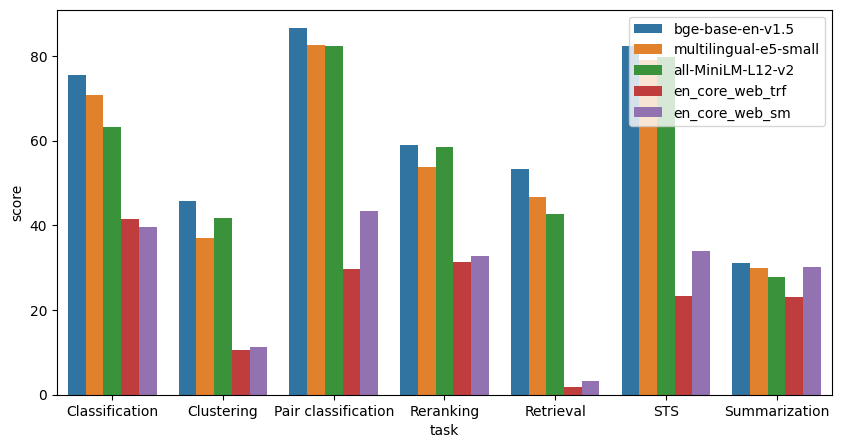

In [2]:
#| label: fig-models
#| fig-cap: Comparison of the models on different task groups

import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("spacy_mteb.csv", header=None, names=["model", "task", "score"])
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(df, x="task", y="score", hue="model", ax=ax)
plt.legend(loc='upper right')
plt.show()

### Observations

1. `en_core_web_trf` is better at classification tasks then `en_core_web_sm` (albeit not by a large margin)
2. `en_core_web_sm` beats `en_core_web_trf` at all other tasks
3. The difference between `bge-base-1.5`, `multilingual-e5-small` and `all-MiniLM-L12-v2` is miniscule
4. Both `en_core_web_trf` and `en_core_web_sm` consistently lack ten or more points behind the models used for comparison

The results are not surprising. If the spaCy authors have followed through on their paper and developed their models for NER classification tasks, it makes sense that they would not (inherently) do well on other tasks. What strikes me as odd is the fact that `en_core_web_trf` only marginally (+ 1.84) outperforms `en_core_web_sm` when ran on a wide class of classification problems.

## Conclusions

1. spaCy models are designed with NER in mind
2. The built-in models of spaCy can't be used for retrieval tasks
3. If one wants to build components in spaCy that are not classification tasks, they should be [using a different Transformer](https://github.com/explosion/spaCy/discussions/10327)

One needs to be wary that fine-tuning other models however may be detrimental to their performance, careful evaluation is necessary before deploying a different then the built-in transformer.

Finally, I would like to emphasize that this is in no way meant to belittle the monumental effort and usefulness of spaCy. It remains a battle-tested software for its designed purpose.

## Acknowledgments

This evaluation wouldn't have been possible without compute that was graciously provided by [YUKKA Lab AG](http://yukkalab.com). Further I would like to thank Mingzhu Wu for all her helpful comments that made this evaluation more complete!